# Baseline Modeling 
We run a linear model and neural network without time or graph dependence to be able to compare with the Graph Neural Network

In [6]:
# magic command to import a bunch of stuff
%pylab

# make plots show up in notebook
%matplotlib inline

import pandas as pd

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib
Mounted at /content/gdrive


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
from tqdm import tqdm 
import os 

In [ ]:
PARENT_DIR = 'gdrive/My Drive/Stat 175 Final Project/'
df = pd.read_csv(f'{PARENT_DIR}climate_plus_claims.csv')

In [ ]:
import torch
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install tensorboardX
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

In [ ]:
# load graph data and extract data matrix
files = os.listdir(f'{PARENT_DIR}data')
data = [torch.load(f'{PARENT_DIR}data/{f}') for f in tqdm(files)]

100%|██████████| 413/413 [01:20<00:00,  5.13it/s]


In [7]:
# get data into pandas format from the graph objects
x_train = pd.concat([pd.DataFrame(data[i].x.numpy()) for i in range(300)])
y_train = pd.concat([pd.DataFrame(data[i].y.numpy()) for i in range(300)])

x_test = pd.concat([pd.DataFrame(data[i].x.numpy()) for i in range(300, 413)])
y_test = pd.concat([pd.DataFrame(data[i].y.numpy()) for i in range(300, 413)])


In [8]:
# train lm 
lm = LinearRegression(fit_intercept = False).fit(x_train, y_train.values)

In [12]:
from sklearn.metrics import mean_squared_error
# model losses 
print(mean_squared_error(lm.predict(x_train), y_train))
mean_squared_error(lm.predict(x_test), y_test)

8904131000.0


75024920000.0

In [57]:
# get predictions for a time window 
def get_preds(window, model=lm):

  # get locations
  locations = pd.read_csv(f'{PARENT_DIR}locations.csv')[['lat','lon']]

  # add predictions and y data 
  locations['preds'] = model.predict(x_test.iloc[1*1029:(1+1)*1029].values)
  locations['y'] = y_test.iloc[window*1029:(window+1)*1029].values

  # compute loss
  loss_window = mean_squared_error(locations['preds'].values, locations['y'].values)

  return locations, loss_window
get_preds(17, lm)

(       lat    lon        preds    y
 0     25.3  279.2  6175.824219  0.0
 1     25.3  279.3  6096.870605  0.0
 2     25.3  279.4  5898.079102  0.0
 3     25.3  279.5  5957.281250  0.0
 4     25.4  278.9  6474.623535  0.0
 ...    ...    ...          ...  ...
 1024  30.9  277.9   612.176941  0.0
 1025  30.9  278.0   606.846985  0.0
 1026  30.9  278.1   599.466370  0.0
 1027  30.9  278.3  1145.992065  0.0
 1028  30.9  278.4  1488.632935  0.0
 
 [1029 rows x 4 columns],
 5686881000000.0)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


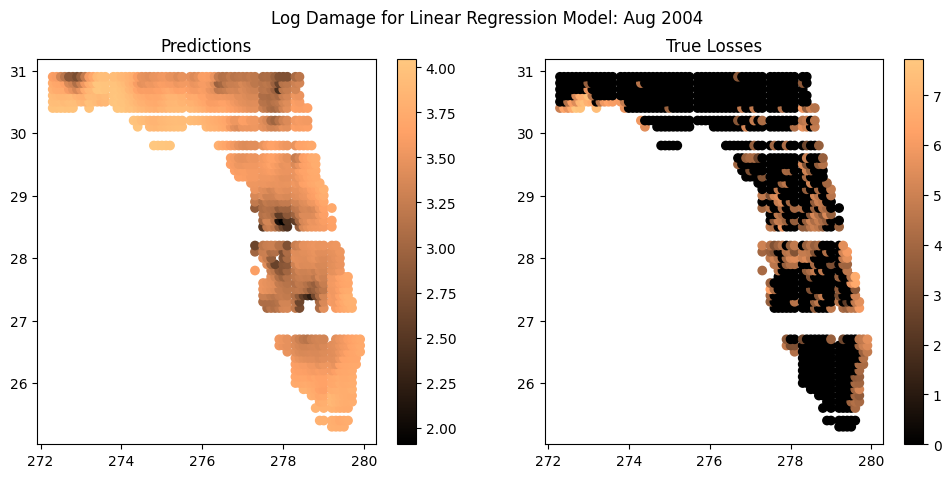

In [58]:
import matplotlib.cm as cm

# plot side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# get data for window
data_plot = get_preds(17, lm)[0]

# plot predictions on left
sc1 = ax[0].scatter(data_plot.lon, data_plot.lat, c=np.log10(data_plot.preds+1), cmap=cm.copper)
cbar1 = fig.colorbar(sc1, ax=ax[0])
#cbar1.ax.set_title("Total Building Damage (Log)")
ax[0].set_title("Predictions")

# plot actual loses on right
sc2 = ax[1].scatter(data_plot.lon, data_plot.lat, c=np.log10(data_plot.y+1), cmap=cm.copper)
cbar2= fig.colorbar(sc2, ax=ax[1])
ax[1].set_title("True Losses")
#cbar2.ax.set_title("Total Building Damage (Log)", rotation=90)
ax[0].annotate("Total Building Damage (log-10 scale)", xy = (.5, .5), rotation = 90)
plt.suptitle("Log Damage for Linear Regression Model: Aug 2004")

plt.savefig(f'{PARENT_DIR}plots/aug_2004_lm.png', dpi =250)

## Neural Network
Below we implement a neural network on the same data as the linear model to see if this model can capture additional information

In [10]:
# Run Neural Network 
import torch
import torch.nn as nn
import torch.optim as optim

# convert data frames to PyTorch tensors
x_train_tensor = torch.tensor(x_train.values).float()
y_train_tensor = torch.tensor(y_train.values).float()

# convert test data to tensors 
x_test_tensor = torch.tensor(x_test.values).float()
y_test_tensor = torch.tensor(y_test.values).float()

In [11]:
# define neural network architecture
model = nn.Sequential(
    nn.Linear(x_train_tensor.shape[1], 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

# train the model
n_epochs = 500
train_losses = []
test_losses = []
for epoch in range(300):
    optimizer.zero_grad()
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # calculate loss on test set 
    test_losses.append(float(torch.nn.functional.mse_loss(model(x_test_tensor), y_test_tensor).detach().numpy()))

    # print summary 
    if epoch % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))


Epoch [1/100], Loss: 8921909248.0000
Epoch [11/100], Loss: 8920973312.0000
Epoch [21/100], Loss: 8918833152.0000
Epoch [31/100], Loss: 8909313024.0000
Epoch [41/100], Loss: 8882520064.0000
Epoch [51/100], Loss: 8821961728.0000
Epoch [61/100], Loss: 8718353408.0000
Epoch [71/100], Loss: 8567597056.0000
Epoch [81/100], Loss: 8376394752.0000
Epoch [91/100], Loss: 8151286784.0000
Epoch [101/100], Loss: 7899672064.0000
Epoch [111/100], Loss: 7631838208.0000
Epoch [121/100], Loss: 7350758400.0000
Epoch [131/100], Loss: 7056412672.0000
Epoch [141/100], Loss: 6759160320.0000
Epoch [151/100], Loss: 6472436224.0000
Epoch [161/100], Loss: 6203606528.0000
Epoch [171/100], Loss: 5952991232.0000
Epoch [181/100], Loss: 5713386496.0000
Epoch [191/100], Loss: 5497490944.0000
Epoch [201/100], Loss: 5277128192.0000
Epoch [211/100], Loss: 5080038400.0000
Epoch [221/100], Loss: 4887164416.0000
Epoch [231/100], Loss: 4714170368.0000
Epoch [241/100], Loss: 4549116928.0000
Epoch [251/100], Loss: 4393649664.00

In [14]:
# print final losses 
print(train_losses[-1])
print(test_losses[-1])

3813372672.0
96480288768.0


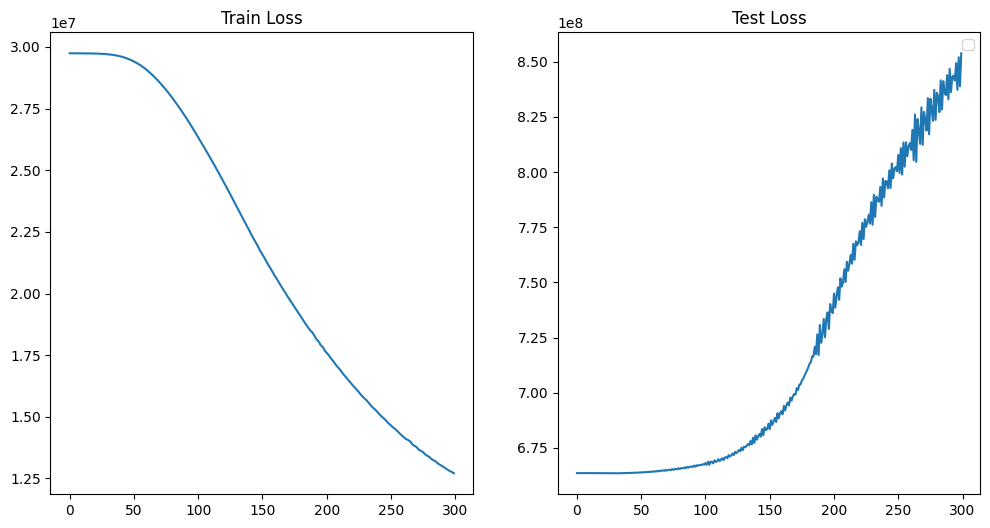

In [13]:
# plot loss curves 
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,2, figsize = (12, 6))
ax[0].plot(np.arange(0,len(train_losses)), np.array(train_losses)/300)
ax[1].plot(np.arange(0, len(test_losses)), np.array(test_losses)/113)

ax[0].set_title("Train Loss")
ax[1].set_title("Test Loss")

plt.legend()
plt.savefig(f'{PARENT_DIR}plots/NN_train_test_loss.png', dpi = 250)

# Plot the Florida map!

In [54]:
def get_preds(window, model=model):

  # get locations
  locations = pd.read_csv(f'{PARENT_DIR}locations.csv')[['lat','lon']]

  # add predictions and y data 
  locations['preds'] = model(torch.tensor(x_test.iloc[1*1029:(1+1)*1029].values)).detach().numpy()
  locations['y'] = y_test.iloc[window*1029:(window+1)*1029].values

  # compute loss
  loss_window = mean_squared_error(locations['preds'].values, locations['y'].values)

  return locations, loss_window

In [44]:
get_preds(17)

(       lat    lon       preds    y
 0     25.3  279.2  373.232086  0.0
 1     25.3  279.3  373.232086  0.0
 2     25.3  279.4  373.232086  0.0
 3     25.3  279.5  373.232086  0.0
 4     25.4  278.9  373.232086  0.0
 ...    ...    ...         ...  ...
 1024  30.9  277.9  373.232086  0.0
 1025  30.9  278.0  373.232086  0.0
 1026  30.9  278.1  373.232086  0.0
 1027  30.9  278.3  373.232086  0.0
 1028  30.9  278.4  373.232086  0.0
 
 [1029 rows x 4 columns],
 5690481400000.0)

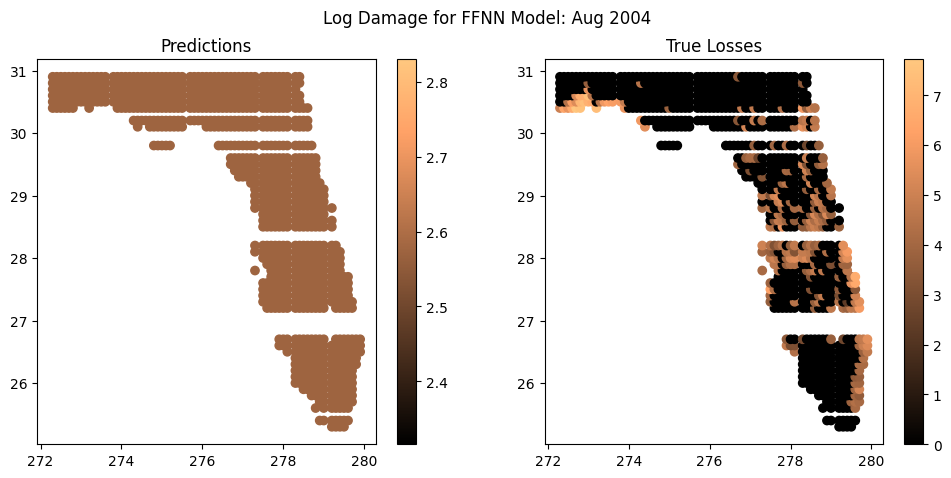

In [56]:
import matplotlib.cm as cm

# plot side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# get data for window
data_plot = get_preds(17)[0]

# plot predictions on left
sc1 = ax[0].scatter(data_plot.lon, data_plot.lat, c=np.log10(data_plot.preds+1), cmap=cm.copper)
cbar1 = fig.colorbar(sc1, ax=ax[0])
#cbar1.ax.set_title("Total Building Damage (Log)")
ax[0].set_title("Predictions")

# plot actual loses on right
sc2 = ax[1].scatter(data_plot.lon, data_plot.lat, c=np.log10(data_plot.y+1), cmap=cm.copper)
cbar2= fig.colorbar(sc2, ax=ax[1])
ax[1].set_title("True Losses")
#cbar2.ax.set_title("Total Building Damage (Log)", rotation=90)
ax[0].annotate("Total Building Damage (log-10 scale)", xy = (.5, .5), rotation = 90)
plt.suptitle("Log Damage for FFNN Model: Aug 2004")

plt.savefig(f'{PARENT_DIR}plots/aug_2004_FFNN.png', dpi =250)